### Code generation with RAG and self-correction
#### link : https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/#graph


In [1]:
from dotenv import load_dotenv
import os
from langchain_openai import AzureOpenAI

# Load environment variables from the .env file
load_dotenv()

# Retrieve credentials from environment variables
openai_api_version = os.getenv("OPENAI_API_VERSION")
azure_openai_endpoint = os.getenv("ENDPOINT_URL_MINI")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_MINI")





In [2]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/docs/concepts/lcel/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(concatenated_content)






LangChain Expression Language (LCEL) | 🦜️🔗 LangChain






Skip to main contentIntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools in a chainHow to use a vectorstore as a retrieverHow to add memory to chatbotsHow to use example selectorsHow to add a semantic layer over graph databaseHow to invoke runnables in parallelHow to stream chat model responsesHow to add default invocation args to a RunnableHow to add retrieval to chatbotsHow to use few sho

In [3]:
from langchain_core.prompts import ChatPromptTemplate

from langchain_openai import AzureChatOpenAI
from pydantic import BaseModel, Field

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")


expt_llm = "gpt-4o-mini"


if not os.environ.get("AZURE_OPENAI_API_KEY"):
  os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key
llm = AzureChatOpenAI(
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=expt_llm,
    openai_api_version=openai_api_version,
)
code_gen_chain_oai = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain_oai.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
res=solution.prefix

In [4]:
res

'To build a Retrieval Augmented Generation (RAG) chain in LangChain Expression Language (LCEL), you can use a combination of Runnables for retrieval and generation. The following code demonstrates how to create a simple RAG chain that retrieves relevant documents from a vector store and then generates a response based on those documents.'

In [5]:
# from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

### Anthropic

# Prompt to enforce tool use
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is the LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user  question based on the \n 
    above provided documentation. Ensure any code you provide can be executed with all required imports and variables \n
    defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block. \n
    Invoke the code tool to structure the output correctly. </instructions> \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# LLM
expt_llm = "claude-3-opus-20240229"


structured_llm_claude = llm.with_structured_output(code, include_raw=True)


# Optional: Check for errors in case tool use is flaky
def check_claude_output(tool_output):
    """Check for parse error or failure to call the tool"""

    # Error with parsing
    if tool_output["parsing_error"]:
        # Report back output and parsing errors
        print("Parsing error!")
        raw_output = str(tool_output["raw"].content)
        error = tool_output["parsing_error"]
        raise ValueError(
            f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
        )

    # Tool was not invoked
    elif not tool_output["parsed"]:
        print("Failed to invoke tool!")
        raise ValueError(
            "You did not use the provided tool! Be sure to invoke the tool to structure the output."
        )
    return tool_output


# Chain with output check
code_chain_claude_raw = (
    code_gen_prompt_claude | structured_llm_claude | check_claude_output
)


def insert_errors(inputs):
    """Insert errors for tool parsing in the messages"""

    # Get errors
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "assistant",
            f"Retry. You are required to fix the parsing errors: {error} \n\n You must invoke the provided tool.",
        )
    ]
    return {
        "messages": messages,
        "context": inputs["context"],
    }


# This will be run as a fallback chain
fallback_chain = insert_errors | code_chain_claude_raw
N = 3  # Max re-tries
code_gen_chain_re_try = code_chain_claude_raw.with_fallbacks(
    fallbacks=[fallback_chain] * N, exception_key="error"
)


def parse_output(solution):
    """When we add 'include_raw=True' to structured output,
    it will return a dict w 'raw', 'parsed', 'parsing_error'."""

    return solution["parsed"]


# Optional: With re-try to correct for failure to invoke tool
code_gen_chain = code_gen_chain_re_try | parse_output

# No re-try
code_gen_chain = code_gen_prompt_claude | structured_llm_claude | parse_output

In [6]:
code_gen_chain

ChatPromptTemplate(input_variables=['context'], optional_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typ

In [50]:
# Test
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution=solution.prefix
solution

'Below is a code example to build a Retrieval-Augmented Generation (RAG) chain using LCEL. This example combines a retriever, a language model, and an output parser to create a RAG system.'

In [51]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

In [52]:
### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [53]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

In [54]:
question = "what is Composition Syntax"
solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---


In [55]:
sol=solution["generation"]
sol=sol.prefix
sol

'This code demonstrates Composition Syntax in LCEL by using the | operator and the .pipe method to create Runnables. It also shows how dictionaries and functions automatically convert to RunnableParallel and RunnableLambda respectively.'

### Creating a Basic Chatbot in LangGraph
#### link : https://blog.futuresmart.ai/langgraph-tutorial-for-beginners

In [76]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


In [77]:
class State(TypedDict):
    # 'messages' will store the chatbot conversation history.
    # The 'add_messages' function ensures new messages are appended to the list.
    messages: Annotated[list, add_messages]

# Create an instance of the StateGraph, passing in the State class
graph_builder = StateGraph(State)


In [78]:
def chatbot(state: State):
    # Use the LLM to generate a response based on the current conversation history.
    response = llm.invoke(state["messages"])

    # Return the updated state with the new message appended
    return {"messages": [response]}

# Add the 'chatbot' node to the graph,
graph_builder.add_node("chatbot", chatbot)


In [79]:
# For this basic chatbot, the 'chatbot' node is both the entry and finish point
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


In [80]:
graph = graph_builder.compile()


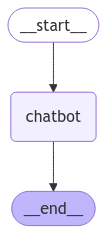

In [81]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [82]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # Process user input through the LangGraph
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


Assistant: Hello! How can I assist you today?
Assistant: I don't have real-time capabilities to check the current weather. I recommend checking a reliable weather website or app for the most accurate and up-to-date information on today's weather.
Goodbye!


#### Tool Integration

Enhancing our Basic Chatbot with Tool Integration

Let's modify the basic chatbot created in the previous section to include a tool that can search the web for information. We'll use the TavilySearchResults tool from langchain_community.tools.tavily_search . You will need Tavily API key for this example.

tool = TavilySearchResults(

    max_results=5,

    search_depth="advanced",

    include_answer=True,

    include_raw_content=True,

    include_images=True,

    # include_domains=[...],

    # exclude_domains=[...],

    # name="...",            # overwrite default tool name

    # description="...",     # overwrite default tool description
    
    # args_schema=...,       # overwrite default args_schema: BaseModel
)

In [105]:
#pip install -U tavily-python langchain_community
from typing import Annotated
from dotenv import load_dotenv
import os

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

load_dotenv()

api_key_tavily = os.getenv("TAVILY_API_KEY")

os.environ['TAVILY_API_KEY']=api_key_tavily


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()


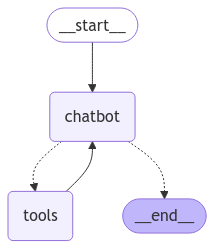

In [106]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [107]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # Process user input through the LangGraph
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


Assistant: Hello! How can I assist you today?
Assistant: Nice to meet you, Shrawan! How can I assist you today?
Assistant: I'm sorry, but I don't know your name. You haven't provided it yet.
Assistant: I'm sorry, but I don't have access to personal data about you unless you've shared it with me in this conversation. If you'd like to tell me your name, I can address you accordingly!
Assistant: Nice to meet you, Shrawan! How can I assist you today?
Assistant: Nice to meet you, Shrawan! How can I assist you today?
Assistant: I'm sorry, but I don't have access to personal information about you, including your name. If you'd like to share your name or provide more context, feel free!
Goodbye!


##### Adding Memory to the Chatbot

In [108]:
# ... (Previous code to define State, graph_builder, nodes, and edges)

from typing import Annotated
from dotenv import load_dotenv
import os

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.memory import MemorySaver




load_dotenv()

api_key_tavily = os.getenv("TAVILY_API_KEY")

os.environ['TAVILY_API_KEY']=api_key_tavily


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)

# Create a MemorySaver object to act as the checkpointer
memory = MemorySaver()


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")







# Compile the graph, passing in the 'memory' object as the checkpointer
graph = graph_builder.compile(checkpointer=memory)



In [109]:
config = {"configurable": {"thread_id": "1"}}


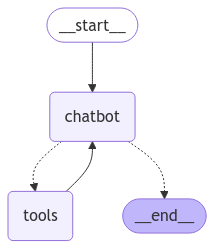

In [110]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [111]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # Process user input through the LangGraph
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


Assistant: Hello, Shrawan! How can I assist you today?
Assistant: Your name is Shrawan.
Goodbye!


#### Human in the Loop
Human-in-the-loop workflows are essential for situations where you want to incorporate human oversight, verification, or decision-making within your AI application.

Implementing Human-in-the-Loop with Interrupts

The below code illustrates human-in-the-loop implementation using LangGraph's interrupt_before or interrupt_after functionality. Here's a breakdown:

In [112]:
from typing import Annotated


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)


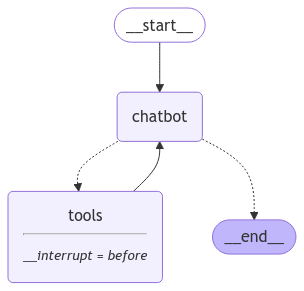

In [113]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass
